# Toggle Time Tracking
markdown-pdf is needed for PDF Report: https://www.npmjs.com/package/markdown-pdf

```npm install -g markdown-pdf```

## Configuration

In [681]:
# ....
# -1 = previous (month|week)
# 0 = current (month|week)
addMonth = -1
addWeek = -1

## Setup

### Import sub-modules

In [682]:
# Import required sub-modules

# python
import sys
import os
import enum
import datetime
from dateutil.parser import parse
import time
import pytz
import json
import re

# iPython
import IPython
from IPython.display import display
from IPython.display import Image

# pandas
import pandas as pd

# numpy
import numpy as np

# plotly
import plotly as ply
import plotly.graph_objs as go
import plotly.figure_factory as ff
ply.offline.init_notebook_mode(connected=True)
import plotly.io as pio

# Toggl Wrapper API 
# https://github.com/matthewdowney/TogglPy
import TogglPy

# Verbose what we are working with
print("python: {}".format(sys.version))
print("    - os")
print("    - datetime")
print("    - enum")

print("ipython {}".format(IPython.__version__))
print("pandas: {}".format(pd.__version__))
print("numpy: {}".format(np.__version__))
print("plotly: {}".format(ply.__version__))

python: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
    - os
    - datetime
    - enum
ipython 7.4.0
pandas: 0.24.2
numpy: 1.16.2
plotly: 3.8.1


### Configuration

In [683]:
# Setup local input directories
inputDir = "input/"
if (os.path.exists(inputDir)) is False:
    os.makedirs(inputDir)
if (os.path.isdir(inputDir)) is False:
    raise NotADirectoryError("{} is not a directory".format(inputDir))

In [684]:
# Setup local input directories
outputDir = "output/"
if (os.path.exists(outputDir)) is False:
    os.makedirs(outputDir)
if (os.path.isdir(outputDir)) is False:
    raise NotADirectoryError("{} is not a directory".format(outputDir))

In [685]:
# Graph output Options
class GraphOutputOption(enum.Enum):
    none = 'none'                     # Do not generate any plots
    inline = 'inline'                 # Generate inline plots only
    htmlFile = 'extFile'              # Generate plots in external files (html or png or ...)
    both = 'both'                     # Generate all plots inline and external
    
class GraphInteractionOption(enum.Enum):
    static = 'static'                 # Generate static inline plots (as images)
    interactive = 'interactive'       # Generate interactive inline plots

notebookGraphingInteraction = GraphInteractionOption('interactive')
notebookGraphingOutputs = GraphOutputOption('both')

ext_file = ".svg"

staticImageSize = {'width':1000, 'height':500, 'scale':1}

GraphAutoOpenHTML = False              # Auto open external HTML files [True/False]

In [686]:
# Pandas output options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

### Common Functions

In [687]:
# Plot figures
def plot_figure(graphFilename, fig, overrideNotebookGraphingInteraction=None, height=350):
    """Creates the graph plots depenmding on the choosen option

    Args:
        graphFilename: Filename of the output html-file in case of Option htmlfile
        fig: ply.graph_objs.Figure(data=traces, layout=mylayout)
        overrideNotebookGraphingInteraction: overrides graphic output for this figure
        height: height of the static image export
    Returns:
        None
    Raises:
        None

    """
    if (notebookGraphingOutputs == GraphOutputOption('extFile')) or (notebookGraphingOutputs == GraphOutputOption('both')):
        if (os.path.splitext(graphFilename)[1] == '.png' or 
           os.path.splitext(graphFilename)[1] == '.jpg' or 
           os.path.splitext(graphFilename)[1] == '.svg' or 
           os.path.splitext(graphFilename)[1] == '.pdf'):
            pio.write_image(fig, graphFilename, height=height)
        elif os.path.splitext(graphFilename)[1] == '.html':
            ply.offline.plot(fig, filename=graphFilename, auto_open=GraphAutoOpenHTML)
    if (notebookGraphingOutputs == GraphOutputOption('inline')) or (notebookGraphingOutputs == GraphOutputOption('both')):
        choice = None
        if overrideNotebookGraphingInteraction == None:
            if notebookGraphingInteraction == GraphInteractionOption('static'):
                choice = 'static'
            elif notebookGraphingInteraction == GraphInteractionOption('interactive'):
                choice = 'interactive'
        elif overrideNotebookGraphingInteraction == GraphInteractionOption('static'):
            choice = 'static'
        elif overrideNotebookGraphingInteraction == GraphInteractionOption('interactive'):
            choice = 'interactive'
        else:
            choice = 'static'
            
        if choice == 'static':
            plot_img = pio.to_image(fig, format='png', width=staticImageSize['width'], height=staticImageSize['height'], scale=staticImageSize['scale'])
            display(Image(plot_img))
        else:
            ply.offline.iplot(fig)
            

In [688]:
def print_file(text="", file=None, fileoutput=True, consoleoutput=True, append=True):
    if fileoutput:
        if append:
            with open(file, "a+") as file:
                file.write(text+"\n")#os.linesep)
        else:
            with open(file, "w+") as file:
                file.write(text+"\n")#os.linesep)
    if consoleoutput:
        print(text)

## Data Import

In [689]:
import json

with open("toggl_credentials.json", "r") as file:
    credentials = json.load(file)
    toggl_cr = credentials['toggl']
    APIKEY = toggl_cr['APIKEY']

toggl = TogglPy.Toggl()
toggl.setAPIKey(APIKEY)

### Get toggle information

In [690]:
toggl_time_entries_url = "https://www.toggl.com/api/v8/time_entries"
toggl_user_url = "https://www.toggl.com/api/v8/me"
toggl_workspaces_url = "https://www.toggl.com/api/v8/workspaces"
toggl_clients_url = "https://www.toggl.com/api/v8/clients"

### User Info

In [691]:
user = pd.DataFrame.from_dict(toggl.request(toggl_user_url))
user

,since,data
achievements_enabled,1561922105,True
api_token,1561922105,28b59df81f3ad452c14b78e563287f77
at,1561922105,2019-06-17T18:12:10+00:00
beginning_of_week,1561922105,1
created_at,1561922105,2016-10-23T11:00:17+00:00
date_format,1561922105,DD.MM.YYYY
default_wid,1561922105,1721871
duration_format,1561922105,improved
email,1561922105,whynotlogic@gmail.com
fullname,1561922105,Whynotlogic


### Workspaces Info

In [692]:
workspaces_list = pd.DataFrame.from_dict(toggl.request(toggl_workspaces_url))
workspaces_list

,admin,api_token,at,default_currency,default_hourly_rate,ical_enabled,id,name,only_admins_may_create_projects,only_admins_see_billable_rates,only_admins_see_team_dashboard,premium,profile,projects_billable_by_default,rounding,rounding_minutes
0,True,9e62c09c28d5823983a9a8e025b8fc72,2016-10-23T11:00:18+00:00,USD,0,True,1721871,Whynotlogic's workspace,False,False,False,False,0,True,1,0


In [693]:
workspaces_list = pd.DataFrame.from_dict(toggl.request(toggl_workspaces_url))
workspaces_list

workspaces = pd.DataFrame()
for wid in workspaces_list['id']:
    workspaces = pd.DataFrame.from_dict(toggl.request(toggl_workspaces_url + "/" + str(wid) + "/clients"))
workspaces

,at,id,name,wid
0,2019-03-06T18:56:37+00:00,43922490,MAS,1721871
1,2019-03-06T18:56:27+00:00,43922487,HESSO,1721871
2,2019-03-06T18:56:23+00:00,43922486,Constellium,1721871


### User Client Info

In [694]:
user_clients = pd.DataFrame.from_dict(toggl.request(toggl_clients_url))
user_clients

,at,id,name,wid
0,2019-03-06T18:56:23+00:00,43922486,Constellium,1721871
1,2019-03-06T18:56:27+00:00,43922487,HESSO,1721871
2,2019-03-06T18:56:37+00:00,43922490,MAS,1721871


### Projects Info

In [695]:
projects = pd.DataFrame()
for i in list(range(0, len(workspaces_list))):
    projects_list = toggl.request(toggl_workspaces_url + "/" + str(workspaces_list['id'][i]) + "/projects")
    projects_df_temp = pd.DataFrame.from_dict(projects_list)
    projects = pd.concat([projects_df_temp, projects])
projects

,active,actual_hours,at,auto_estimates,billable,cid,color,created_at,hex_color,id,is_private,name,template,wid
0,True,18.0,2019-03-14T11:07:28+00:00,False,False,43922486,5,2019-03-14T11:06:35+00:00,#4bc800,150235579,True,Admin,False,1721871
1,True,56.0,2019-03-14T15:21:47+00:00,False,False,43922487,2,2019-03-06T18:57:53+00:00,#ea468d,150034131,True,Admin,False,1721871
2,True,19.0,2019-03-21T15:01:49+00:00,False,False,43922487,2,2019-03-14T15:21:39+00:00,#ea468d,150242002,True,Apero Creation,False,1721871
3,True,45.0,2019-04-11T07:37:22+00:00,False,False,43922487,3,2019-04-11T07:37:22+00:00,#fb8b14,150954342,True,Aquisition de projects,False,1721871
4,True,32.0,2019-04-11T07:36:46+00:00,False,False,43922486,5,2019-03-21T14:36:52+00:00,#4bc800,150388106,True,Aquisition de projects,False,1721871
5,True,81.0,2019-04-11T07:34:25+00:00,False,False,43922486,14,2019-04-11T07:34:25+00:00,#000000,150954300,True,ASI - DPP,False,1721871
6,True,133.0,2019-04-11T07:33:55+00:00,False,False,43922486,3,2019-03-20T16:31:46+00:00,#fb8b14,150366067,True,AT - USP,False,1721871
7,True,116.0,2019-04-30T06:42:23+00:00,False,False,43922487,11,2019-04-30T06:42:17+00:00,#205500,151295149,True,Compensation,False,1721871
8,True,83.0,2019-04-11T07:38:08+00:00,False,False,43922487,2,2019-03-21T15:01:32+00:00,#ea468d,150388923,True,Cours dispensé,False,1721871
9,True,NaN,2019-04-11T07:38:39+00:00,False,False,43922486,1,2019-04-11T07:38:39+00:00,#c56bff,150954375,True,Formation Continue,False,1721871


### Time Entries

#### Some standart functions

In [696]:

def fill_clean_timeentries(df, projects, user_clients):
    # Add project name and client name to dataframe
    df['project'] = df.pid.map(projects.set_index('id')['name'].to_dict())
    projects['client'] = projects.cid.map(user_clients.set_index('id')['name'].to_dict())
    df['client'] = df.pid.map(projects.set_index('id')['client'].to_dict())
    # drop unused columns
    drop_columns = ['at', 'billable', 'duronly', 'guid', 'id', 'pid', 'uid', 'wid']
    df = df.drop(drop_columns, axis=1)
    # rearrange columns
    df = df[['client', 'project', 'description', 'start', 'stop', 'duration']]
    # calculate timedelta
    df['duration'] = pd.to_timedelta(df['duration'], unit='sec')
    # transform to datetime
    df['start'] = pd.to_datetime(df['start'])
    df['stop'] = pd.to_datetime(df['stop'])
    
    return df
    
#latest_time_entries = pd.DataFrame.from_dict(toggl.request(toggl_time_entries_url))
#latest_time_entries = fill_clean_timeentries(latest_time_entries, projects, user_clients)
#latest_time_entries.head

In [697]:
def get_join_date():
    join_date = parse(user['data']['created_at'])
    join_date = join_date.replace(tzinfo=None)
    return join_date

def get_today_date():
    today = datetime.datetime.now()
    return today

def get_last_dom(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    return next_month - datetime.timedelta(days=next_month.day)

def get_first_dom(any_day):
    any_day = any_day.replace(day=1)
    return any_day

def get_month(addMonth = 0):
    if addMonth > 0:
        date = get_today_date() + datetime.timedelta(addMonth*365/12)
    elif addMonth < 0:
        date = get_today_date() - datetime.timedelta(-1*addMonth*365/12)
    else:
        date = get_today_date()
    startdate = get_first_dom(date)
    enddate = get_last_dom(date)
    return startdate, enddate

def get_week(date, addWeek = 0):
    if addWeek > 0:
        startdate = date - datetime.timedelta(days=date.weekday()) + datetime.timedelta(days=addWeek*7)
    elif addWeek < 0:
        startdate = date - datetime.timedelta(days=date.weekday()) - datetime.timedelta(days=-1*addWeek*7)
    else:
        startdate = date - datetime.timedelta(days=date.weekday())
    enddate = startdate + datetime.timedelta(days=6)
    return startdate, enddate

def get_weekNbr(date):
    return date.strftime("%V")

# Function that turns datetimes back to strings since that's what the API likes
def date_only(datetimeVal):
    datePart = datetimeVal.strftime("%Y-%m-%d")
    return datePart

def filterByMonth(df, addMonth = 0):
    (startdate, enddate) = get_month(addMonth)
    filteredTimeEntriesDf = df[(df['start'] > startdate.strftime('%Y-%m-%d')) & (df['start'] < enddate.strftime('%Y-%m-%d'))]
    return filteredTimeEntriesDf, startdate, enddate
    #timeEntriesDf[(timeEntriesDf['start'] > '2019-03-23 07:30:00') & (timeEntriesDf['start'] < '2019-04-23 09:00:00')]
    #timeEntriesDf[(timeEntriesDf['start'] > '2019-03-23') & (timeEntriesDf['start'] < '2019-04-23')]

def filterByWeek(df, date, addWeek = 0):
    (startdate, enddate) = get_week(get_today_date(), addWeek)
    filteredTimeEntriesDf = df[(df['start'] > startdate.strftime('%Y-%m-%d')) & (df['start'] < enddate.strftime('%Y-%m-%d'))]
    return filteredTimeEntriesDf, startdate, enddate

In [698]:
# Extract Timelogs Between Two Dates and Export to a CSV
def toggl_timelog_extractor(input_date1, input_date2, save_csv=False, outputdir='output'):
    date1 = parse(input_date1).isoformat() + '+00:00'
    date2 = parse(input_date2).isoformat() + '+00:00'
    param = {
        'start_date': date1,
        'end_date': date2,
    } 
    try:
        temp_log =  pd.DataFrame.from_dict(toggl.request(toggl_time_entries_url, parameters=param))
        if save_csv:
            if not os.path.exists(outputdir + '/detailed/'):
                os.makedirs(outputdir + '/detailed/')
            temp_log.to_csv(outputdir + '/detailed/toggl-time-entries-' + input_date1 + '.csv')
    except: 
        # try again if there is an issue the first time
        temp_log =  pd.DataFrame.from_dict(toggl.request(toggl_time_entries_url, parameters=param))
        if save_csv:
            if not os.path.exists(outputdir + '/daily-detailed/'):
                os.makedirs(outputdir + '/detailed/')
            temp_log.to_csv(outputdir + '/detailed/toggl-time-entries-' + input_date1 + '.csv')
    return temp_log

In [699]:
# Beautify Panda Groupby report
def panda_groupby_md(pd_report):
    string  = "| Project | Time |\n"
    string += "| ------- | ---- |\n"
    for line in pd_report.splitlines():
        if (not(re.search(r"project", line)) and not(re.search(r"Name:", line))):
            string += "| "
            string += re.sub('\s{2,}', " | ", line).strip()
            string += " |\n"
    return string

#### Get all time entries

In [700]:
date1 = date_only(get_join_date())
date2 = date_only(get_today_date())
timeEntriesDf = toggl_timelog_extractor(date1, date2)
timeEntriesDf = fill_clean_timeentries(timeEntriesDf, projects, user_clients)

## Analytics

### Monthly

In [701]:
# Filter by month
(monthlyTimeEntiresDf, monthlystartdate, monthlyenddate) = filterByMonth(timeEntriesDf, addMonth) # -1 = previous month
#monthlyTimeEntiresDf

In [702]:
# Define output file
monthlyreportFile = "Month_{}_Report".format(monthlystartdate.strftime('%Y-%m'))
monthlyreportFilePath = graphFilename = outputDir + monthlyreportFile + ".md"
print_file("# {}".format(monthlyreportFile.replace("_", " ")), monthlyreportFilePath, True, False, False)
print_file("", monthlyreportFilePath, True, False)

#### Parameter Unique Values

In [703]:
dfSize = monthlyTimeEntiresDf.shape
paramList = list(monthlyTimeEntiresDf)
print_file("| {:>11} | {:13} | {:10} | ".format("Parameter", "Unique Values", "Total Rows"), monthlyreportFilePath, False, True)
print_file("|{}|{}|{}|".format(13*"-", 15*"-", 12*"-"), monthlyreportFilePath, False, True)
for param in paramList:
    uniqueEntries = monthlyTimeEntiresDf[param].unique()
    uniqueEntryOccurence = uniqueEntries.shape[0]
    print_file("| {:>11} | {:13} | {:10} | ".format(param, uniqueEntryOccurence, dfSize[0]), monthlyreportFilePath, False, True)
print_file("", monthlyreportFilePath, False, False)

|   Parameter | Unique Values | Total Rows | 
|-------------|---------------|------------|
|      client |             2 |         38 | 
|     project |             7 |         38 | 
| description |            20 |         38 | 
|       start |            38 |         38 | 
|        stop |            36 |         38 | 
|    duration |            10 |         38 | 


#### Summary of Working Hours

In [704]:
# Split Dataframe by Clients
uniqueEntries = monthlyTimeEntiresDf['client'].unique()
clientDfs = []
for uniqueEntry in uniqueEntries:
    clientDfs.append(monthlyTimeEntiresDf[monthlyTimeEntiresDf['client'] == uniqueEntry])     

In [705]:
print_file("## Monthly Working Hours per Clients and Project", monthlyreportFilePath, True, True)
print_file("Timeframe: {} => {}".format(monthlystartdate.strftime('%d-%m-%Y'), monthlyenddate.strftime('%d-%m-%Y')), monthlyreportFilePath, False, True)

for i in range(len(clientDfs)):
    print_file("### Client {}".format(uniqueEntries[i]), monthlyreportFilePath, True, True)
    clientDfs[i]['duration_hours'] = (clientDfs[i]['duration'].dt.total_seconds() / 3600)
    print_file(panda_groupby_md(str(clientDfs[i].groupby('project')['duration_hours'].sum())), monthlyreportFilePath, True, True)
    print_file("", monthlyreportFilePath, True, True)    
print_file("", monthlyreportFilePath, True, False)

## Monthly Working Hours per Clients and Project
Timeframe: 01-06-2019 => 30-06-2019
### Client HESSO
| Project | Time |
| ------- | ---- |
| Admin | 9.25 |
| Compensation | 32.00 |
| Cours dispensé | 25.00 |
| Zivilschutz | 8.00 |


### Client Constellium
| Project | Time |
| ------- | ---- |
| AT - USP | 52.25 |
| Smart Process Lab | 3.50 |




### Weekly

In [706]:
# Filter by week
(weeklyTimeEntiresDf, weeklystartdate, weeklyenddate) = filterByWeek(timeEntriesDf, get_today_date(), addWeek)
#weeklyTimeEntiresDf

In [707]:
# Define output file
weeklyreportFile = "Week_{}_Report".format(get_weekNbr(weeklystartdate))
weeklyreportFilePath = graphFilename = outputDir + weeklyreportFile + ".md"
print_file("# {}".format(weeklyreportFile.replace("_", " ")), weeklyreportFilePath, True, False, False)
print_file("", weeklyreportFilePath, True, False)

#### Summary of Working Hours

In [708]:
# Split Dataframe by Clients
uniqueEntries = weeklyTimeEntiresDf['client'].unique()
clientDfs = []
for uniqueEntry in uniqueEntries:
    clientDfs.append(weeklyTimeEntiresDf[weeklyTimeEntiresDf['client'] == uniqueEntry])     

In [709]:
print_file("## Weekly Working Hours per Clients and Project", weeklyreportFilePath, True, True)
print_file("Week Number: {}".format(get_weekNbr(weeklystartdate)), weeklyreportFilePath, False, True)
print_file("Timeframe: {} => {}".format(weeklystartdate.strftime('%d-%m-%Y'), weeklyenddate.strftime('%d-%m-%Y')), weeklyreportFilePath, False, True)
for i in range(len(clientDfs)):
    print_file("### Client {}".format(uniqueEntries[i]), weeklyreportFilePath, True, True)
    clientDfs[i]['duration_hours'] = (clientDfs[i]['duration'].dt.total_seconds() / 3600)
    print_file(panda_groupby_md(str(clientDfs[i].groupby('project')['duration_hours'].sum())), weeklyreportFilePath, True, True)
    print_file("", weeklyreportFilePath, True, True)

## Weekly Working Hours per Clients and Project
Week Number: 26
Timeframe: 24-06-2019 => 30-06-2019
### Client Constellium
| Project | Time |
| ------- | ---- |
| AT - USP | 22.0 |


### Client HESSO
| Project | Time |
| ------- | ---- |
| Compensation | 8.00 |
| Zivilschutz | 8.00 |




## Visualizations

### Monthly

#### Working Hours Pie Chart

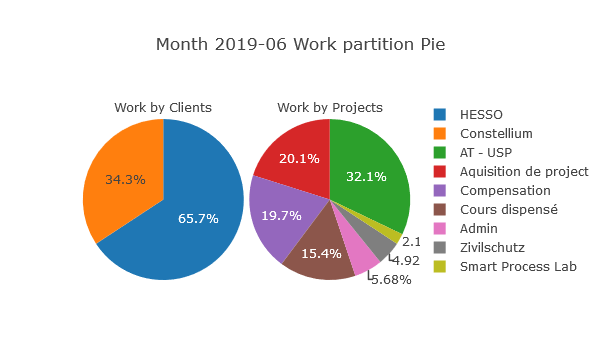

In [710]:
title = "Work by Clients"
labels = monthlyTimeEntiresDf['client']
values = monthlyTimeEntiresDf['duration']
trace1 = go.Pie(title=title,
                labels=labels,
                values=values,
                hoverinfo='label+percent+value',
                domain=dict(x=[0,0.5]))

title = "Work by Projects"
labels = monthlyTimeEntiresDf['project']
values = monthlyTimeEntiresDf['duration']
trace2 = go.Pie(title=title,
                labels=labels,
                values=values,
                hoverinfo='label+percent+value',
                domain=dict(x=[0.5,1.0]))

title = "Month {} Work partition Pie".format(monthlystartdate.strftime('%Y-%m'))
layout = go.Layout(title=title,
                   #annotations=[ann1,ann2],
                   # Hide legend if you want
                   #showlegend=False
                   )

data = [trace1, trace2]
# Create fig with data and layout
fig = go.Figure(data=data,layout=layout)

graphFilename = (title + ext_file).replace(" ", "_")
plot_figure(outputDir + graphFilename, fig)

# Add to report
print_file("![{}]({})".format(title, "." + os.sep + graphFilename), monthlyreportFilePath, True, False)
print_file("", monthlyreportFilePath, True, False)

#### Working Hours Bar Chart

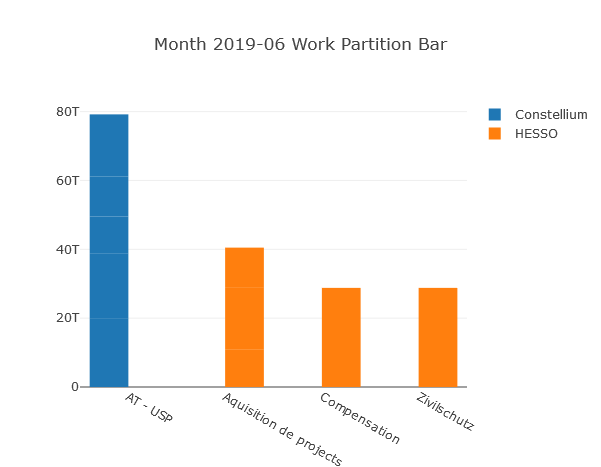

In [711]:
title = "Month {} Work Partition Bar".format(monthlystartdate.strftime('%Y-%m'))
clientDfs[0]['duration'] = clientDfs[0]['duration'].apply(lambda x: pd.to_timedelta(x, unit='h'))
labels = clientDfs[0]['project']
values = clientDfs[0]['duration']
trace1 = go.Bar(name=uniqueEntries[0],
                x=labels,
                y=values
                #hoverinfo='label+percent+value'
                #domain=dict(x=[0,0.5])
               )

labels = clientDfs[1]['project']
values = clientDfs[1]['duration']
trace2 = go.Bar(name=uniqueEntries[1],
                x=labels,
                y=values
                #hoverinfo='label+percent+value',
                #domain=dict(x=[0.5,1])
               )

layout = go.Layout(title=title,
                   #annotations=[ann1,ann2],
                   # Hide legend if you want
                   #showlegend=False
                   )

data = [trace1, trace2]
# Create fig with data and layout
fig = go.Figure(data=data, layout=layout)

graphFilename = (title + ext_file).replace(" ", "_")
plot_figure(outputDir + graphFilename, fig)

# Add to report
print_file("![{}]({})".format(title, "." + os.sep + graphFilename), monthlyreportFilePath, True, False)
print_file("", monthlyreportFilePath, True, False)

### Weekly

#### Working Hours Pie Chart

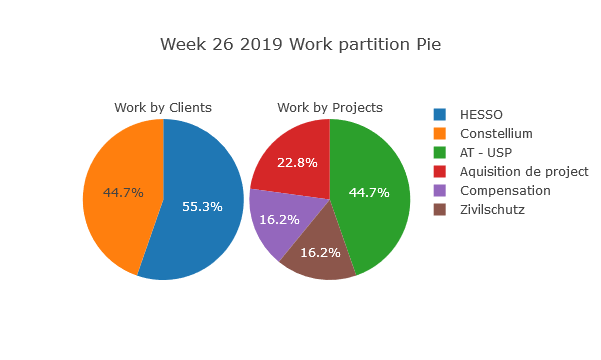

In [712]:
title = "Work by Clients"
labels = weeklyTimeEntiresDf['client']
values = weeklyTimeEntiresDf['duration']
trace1 = go.Pie(title=title,
                labels=labels,
                values=values,
                hoverinfo='label+percent+value',
                domain=dict(x=[0,0.5]))

title = "Work by Projects"
labels = weeklyTimeEntiresDf['project']
values = weeklyTimeEntiresDf['duration']
trace2 = go.Pie(title=title,
                labels=labels,
                values=values,
                hoverinfo='label+percent+value',
                domain=dict(x=[0.5,1.0]))

title = "Week {} {} Work partition Pie".format(get_weekNbr(weeklystartdate), weeklystartdate.strftime('%Y'))
layout = go.Layout(title=title,
                   #annotations=[ann1,ann2],
                   # Hide legend if you want
                   #showlegend=False
                   )

data = [trace1, trace2]
# Create fig with data and layout
fig = go.Figure(data=data,layout=layout)

graphFilename = (title + ext_file).replace(" ", "_")
plot_figure(outputDir + graphFilename, fig)

# Add to report
print_file("![{}]({})".format(title, "." + os.sep + graphFilename), weeklyreportFilePath, True, False)
print_file("", weeklyreportFilePath, True, False)

#### Working Hours Bar Chart

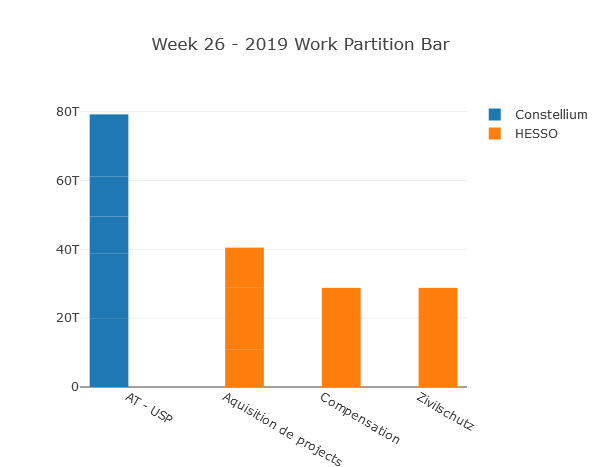

In [713]:
title = "Week {} - {} Work Partition Bar".format(get_weekNbr(weeklystartdate), weeklystartdate.strftime('%Y'))
clientDfs[0]['duration'] = clientDfs[0]['duration'].apply(lambda x: pd.to_timedelta(x, unit='h'))
labels = clientDfs[0]['project']
values = clientDfs[0]['duration']
trace1 = go.Bar(name=uniqueEntries[0],
                x=labels,
                y=values
                #hoverinfo='label+percent+value'
                #domain=dict(x=[0,0.5])
               )

labels = clientDfs[1]['project']
values = clientDfs[1]['duration']
trace2 = go.Bar(name=uniqueEntries[1],
                x=labels,
                y=values
                #hoverinfo='label+percent+value',
                #domain=dict(x=[0.5,1])
               )

layout = go.Layout(title=title,
                   #annotations=[ann1,ann2],
                   # Hide legend if you want
                   #showlegend=False
                   )

data = [trace1, trace2]
# Create fig with data and layout
fig = go.Figure(data=data, layout=layout)

graphFilename = (title + ext_file).replace(" ", "_")
plot_figure(outputDir + graphFilename, fig)

# Add to report
print_file("![{}]({})".format(title, "." + os.sep + graphFilename), weeklyreportFilePath, True, False)
print_file("", weeklyreportFilePath, True, False)

## Generate PDF Report

In [714]:
print(os.getcwd())

C:\Users\silvan.zahno\Workspace\Dropbox\Programming\ipython\04_HEVS\Time


In [715]:
dirlist = os.listdir(outputDir)
os.chdir(outputDir)
for file in dirlist:
    if re.search(".md", file):
        cmd = "markdown-pdf {}".format(file)
        print(cmd)
        if os.system(cmd) == 0:
            print("  * PDF Report {} generated".format(file.replace(".md", ".pdf")))
        else:
            print("  * PDF Report {} failed!!!!".format(file.replace(".md", ".pdf")))
print(os.getcwd())
os.chdir(".\..")

markdown-pdf Month_2019-06_Report.md
  * PDF Report Month_2019-06_Report.pdf generated
markdown-pdf Week_26_Report.md
  * PDF Report Week_26_Report.pdf generated
C:\Users\silvan.zahno\Workspace\Dropbox\Programming\ipython\04_HEVS\Time\output
